1. Теперь решаем задачу регрессии - предскажем цены на недвижимость. Использовать датасет www.kaggle.com...iques/data (train.csv)
2. Данных немного, поэтому необходимо использовать 10-fold кросс-валидацию для оценки качества моделей
3. Построить случайный лес, вывести важность признаков
4. Обучить стекинг как минимум 3х моделей, использовать хотя бы 1 линейную модель и 1 нелинейную
5. Для валидации модели 2-го уровня использовать отдельный hold-out датасет, как на занятии
6. Показать, что использование ансамблей моделей действительно улучшает качество (стекинг vs другие модели сравнивать на hold-out)
7. В качестве решения: Jupyter notebook с кодом, комментариями и графиками

In [123]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import ExtraTreeRegressor

In [30]:
data = pd.read_csv('train.csv')

In [31]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [32]:
#Не буду сильно анализировать данные, сделаю как в ноутбуке к лекции: уберу id и наделаю кучу бинарных признаков.
categorials = list(data.dtypes[data.dtypes == object].index)

categorials_nunique = data[categorials].nunique()

data[categorials] = data[categorials].fillna('nan')

In [33]:
integer = [f for f in data if f not in (categorials + ['Id', 'SalePrice'])]

In [34]:
dummies = pd.get_dummies(data[categorials], columns=categorials)

dummy_cols = list(set(dummies))

data_plus = pd.concat([data[integer].fillna(-999), dummies], axis=1)
X = data_plus
y = data['SalePrice']

In [35]:
data_plus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 304 entries, MSSubClass to SaleCondition_Partial
dtypes: float64(3), int64(33), uint8(268)
memory usage: 792.9 KB


In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [81]:
randomtrees = RandomForestRegressor()
randomtrees.fit(X_train, y_train)
randomtrees.score(X_train, y_train)

0.9764557676024518

In [82]:
randomtrees.score(X_test, y_test)

0.900307719007201

In [42]:
cross_val_score(randomtrees, X_train, y_train, cv=10).mean()

0.8314764806960937

In [47]:
cross_val_score(randomtrees, X_test, y_test, cv=10).mean()

0.8416785759198726

RandomForest стабильно показывает переобучение на стандартной метрике, но cross_val_score демонстрирует, что на самом деле переобучения нет: результаты на тестовой выборке улучшаются

In [83]:
#Заменила критерий оценки, это позволило немного улучшить результаты.
#Изменение других параметров к заметным изменениям не привело
randomtrees_abs = RandomForestRegressor(criterion = 'absolute_error')
randomtrees_abs.fit(X_train, y_train)
randomtrees_abs.score(X_train, y_train)

0.9761664631609979

In [84]:
randomtrees_abs.score(X_test, y_test)

0.8877165581917645

In [50]:
cross_val_score(randomtrees_abs, X_train, y_train, cv=10).mean()

0.8252887601725718

In [51]:
cross_val_score(randomtrees_abs, X_test, y_test, cv=10).mean()

0.8529428710031967

In [101]:
col_value = sorted(list(zip(list(X_train), randomtrees_abs.feature_importances_)), key = lambda x: x[1], reverse=True)[:10]

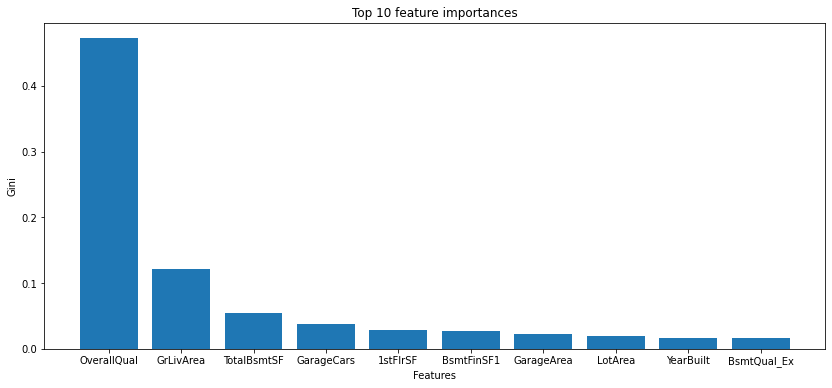

In [102]:
#В принципе результаты на графике похожи на то, что получилось в ноутбуке к лекции: есть самый важный признак,
# есть сильно уступающий ему второй, все остальные гораздо менее значимы.
plt.figure(figsize=(14, 6))
plt.title('Top 10 feature importances')
plt.xlabel('Features')
plt.ylabel('Gini')
plt.bar([x[0] for x in col_value], [x[1] for x in col_value])
plt.show()

In [128]:
#В стек положила RandomForest, потому что было интересно, улучшится ли в этом случае cross_value_score. Спойлер: не улучшилась.
Regressor = StackingRegressor(
    [
        ('Lasso', LassoCV(cv=10)),
        ('KNeighborsRegressor', KNeighborsRegressor()),
        ('RandomForestRegressor', RandomForestRegressor()),
        ('LinearRegression', LinearRegression())
    ], RidgeCV(cv=10))

In [125]:
Regressor.fit(X_train, y_train)

StackingRegressor(estimators=[('Lasso', LassoCV(cv=10)),
                              ('KNeighborsRegressor', KNeighborsRegressor()),
                              ('RandomForestRegressor', RandomForestRegressor(),
                               'LinearRegression', LinearRegression())],
                  final_estimator=RidgeCV(alphas=array([ 0.1,  1. , 10. ]),
                                          cv=10))

In [133]:
score_train = {}
score_test = {}

for i in Regressor.named_estimators:
    score_train[i] = cross_val_score(Regressor.named_estimators[i], X_train, y_train, cv=10).mean()
    score_test[i] = cross_val_score(Regressor.named_estimators[i], X_test, y_test, cv=10).mean()

score_train['Total'] = cross_val_score(Regressor, X_train, y_train, cv=10).mean()
score_test['Total'] = cross_val_score(Regressor, X_test, y_test, cv=10).mean()

In [135]:
print(f"Score on train data {score_train['Total']}")
print(f"Score on test data {score_test['Total']}")

for i in Regressor.named_estimators:
    print(f"Score on train data with model {i} {score_train[i]}")
    print(f"Score on test data with model {i} {score_test[i]}")

Score on train data 0.8394166570432413
Score on test data 0.849053730225846
Score on train data with model Lasso 0.6654939497243063
Score on test data with model Lasso 0.764304955418318
Score on train data with model KNeighborsRegressor 0.6362213845613461
Score on test data with model KNeighborsRegressor 0.594663796557721
Score on train data with model RandomForestRegressor 0.8217104606176525
Score on test data with model RandomForestRegressor 0.8428642319269724
Score on train data with model LinearRegression 0.5861635442410076
Score on test data with model LinearRegression 0.5019269296403241


Стек только на сотые доли смог улучшить результат RandomForest. Линейная регрессия не прошла проверку cross_val_score и показала результаты близки к случайным. Соседи переобучились. Лассо показала неплохой результат на тестовой выборке.

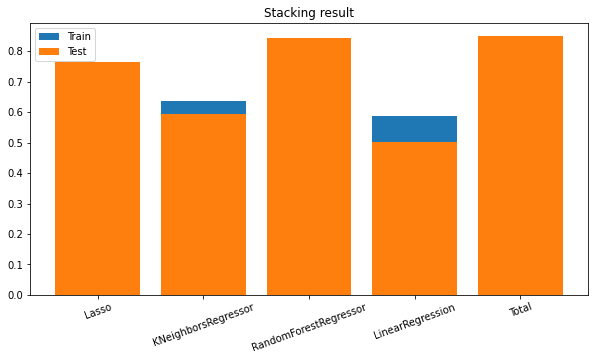

In [138]:
plt.figure(figsize=(10,5))
plt.bar(range(len(score_train)), score_train.values(), align="center", label='Train')
plt.xticks(range(len(score_train)), list(score_train.keys()))
plt.bar(range(len(score_test)), score_test.values(), align="center", label='Test')
plt.xticks(range(len(score_test)), list(score_test.keys()),rotation=20)
plt.autoscale
plt.title('Stacking result')
plt.legend()